In [1]:
import os
import glob

from tqdm import tqdm

import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import sys
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.Grid as hGrid
importlib.reload(hGrid);

In [2]:
def list_nc_files(base_dir):
    # This function will return a list of all .nc files in the directory and its subdirectories
    nc_files = []
    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        # Filter for .nc files
        for file in files:
            if file.endswith(".nc4"):
                full_path = os.path.join(root, file)
                nc_files.append(full_path)
    
    nc_files.sort() 
    return nc_files

base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"
nc_file_list = list_nc_files(base_dir)

In [5]:
#ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
ref_lon, ref_lat = hGrid.generate_lat_lon_e2grid('3km')
data_count = np.zeros_like(ref_lat, dtype=int)
# Flatten the reference arrays and stack them as [latitude, longitude]
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))
tree = cKDTree(ref_points)

Processing row 0/4872
Processing row 100/4872
Processing row 200/4872
Processing row 300/4872
Processing row 400/4872
Processing row 500/4872
Processing row 600/4872
Processing row 700/4872
Processing row 800/4872
Processing row 900/4872
Processing row 1000/4872
Processing row 1100/4872
Processing row 1200/4872
Processing row 1300/4872
Processing row 1400/4872
Processing row 1500/4872
Processing row 1600/4872
Processing row 1700/4872
Processing row 1800/4872
Processing row 1900/4872
Processing row 2000/4872
Processing row 2100/4872
Processing row 2200/4872
Processing row 2300/4872
Processing row 2400/4872
Processing row 2500/4872
Processing row 2600/4872
Processing row 2700/4872
Processing row 2800/4872
Processing row 2900/4872
Processing row 3000/4872
Processing row 3100/4872
Processing row 3200/4872
Processing row 3300/4872
Processing row 3400/4872
Processing row 3500/4872
Processing row 3600/4872
Processing row 3700/4872
Processing row 3800/4872
Processing row 3900/4872
Processing r

In [6]:
# Load the first NetCDF file
for i, file_name in tqdm(enumerate(nc_file_list[:500]), total=len(nc_file_list[:500]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    # Assume the latitude and longitude variable names are known
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    # Stack satellite latitudes and longitudes
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    np.add.at(data_count, (rows, cols), 1)

Processing Files: 100%|███████████████████████████████████████| 500/500 [02:57<00:00,  2.81it/s]


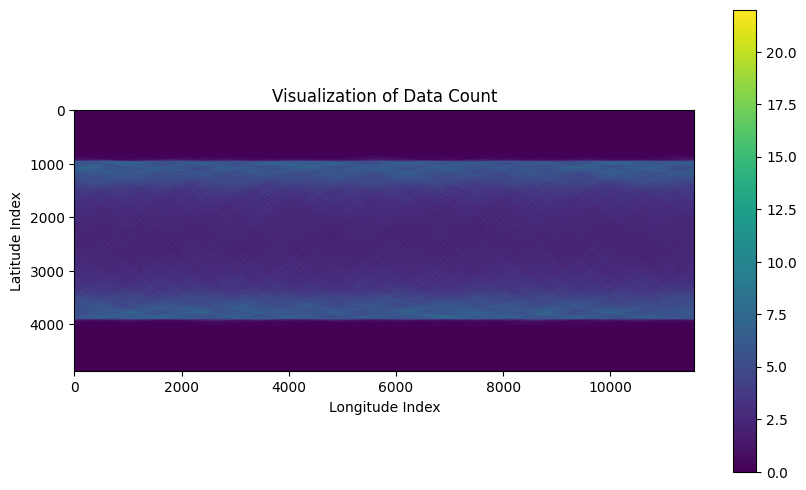

In [9]:
plt.figure(figsize=(10, 6))
im = plt.imshow(data_count, cmap='viridis')
#im = plt.imshow(mean_angles, cmap='viridis')
plt.colorbar(im)
plt.title("Visualization of Data Count")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

In [ ]:
# Initialize a dictionary to hold lists of sp_inc_angle values for each grid cell
from collections import defaultdict
angle_data = defaultdict(list)

for i, file_name in tqdm(enumerate(nc_file_list[:1000]), total=len(nc_file_list[:1000]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    # Extract latitude, longitude, and incidence angle
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()

    # Stack satellite latitudes and longitudes
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)

    # Get the row and column indices in the reference grid
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    # Store sp_inc_angle values in the dictionary
    for idx, angle in zip(indices, sp_inc_angle):
        angle_data[idx].append(angle)

In [ ]:
mean_angles = {idx: np.mean(angles) for idx, angles in angle_data.items()}

In [ ]:
plt.hist(angle_data[97857])

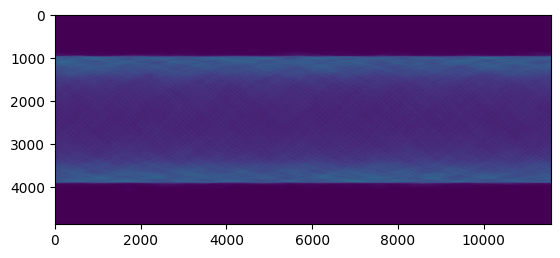

In [7]:
plt.imshow(data_count)